In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
# from utils.helpers import helpers
# from utils.pipelines import grid, clf_adaboost
from utils.helpers import print_cross_validation
from sklearn.model_selection import cross_validate
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix


/tmp/ipykernel_5240/869041540.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
!ls data-technical-test-master/data/CIV.csv

data-technical-test-master/data/CIV.csv


In [3]:
!ls data-technical-test-master/data/

CIV.csv      COM.csv	  CRIM.csv	download-data.sh  SOC.csv
CIV.csv.zip  COM.csv.zip  CRIM.csv.zip	README.md	  SOC.csv.zip


# Import data

In [4]:
df_civ = pd.read_csv("data-technical-test-master/data/CIV.csv", encoding='utf-8', header=None)
df_soc = pd.read_csv("data-technical-test-master/data/SOC.csv", encoding='utf-8', header=None)
df_crim = pd.read_csv("data-technical-test-master/data/CRIM.csv", encoding='utf-8', header=None)
df_com = pd.read_csv("data-technical-test-master/data/COM.csv", encoding='utf-8', header=None)

# Preprocess html text

In [5]:
def clean_text(df):
    # Function to extract text from HTML-like content
    def extract_text(html_content):
        soup = BeautifulSoup(html_content, 'html.parser')
        cleaned_text = soup.get_text(separator=' ', strip=True)  # Replace '\n' with space
        return ' '.join(cleaned_text.split())  # Remove extra spaces and multiple consecutive newlines
    
        # soup = BeautifulSoup(html_content, 'html.parser')
        # return soup.get_text(separator='\n', strip=True)
    
    # Apply the function to the 'column_name' column containing the HTML-like content
    df['Cleaned_Content'] = df[df.columns[0]].apply(extract_text)
    return df

In [6]:
dfs_list = [df_civ, df_soc, df_crim, df_com]
for df in dfs_list:
    clean_text(df)

In [7]:
df_civ[['Cleaned_Content',df_civ.columns[1]]].head()

,Cleaned_Content,1
0,COUR D'APPEL DE BASTIA CHAMBRE CIVILE Ch. civi...,CIV
1,Ch. civile A ARRET No du 12 FEVRIER 2014 R. G ...,CIV
2,COUR D'APPEL DE LYON Troisième Chambre Civile ...,CIV
3,Ch. civile B ARRET du 08 JUIN 2011 R. G : 10/ ...,CIV
4,R. G : 09/ 01472 décision du Tribunal de Grand...,CIV


# With Adaboost

## Data preparation

In [10]:
# Load your data from CSV files
civil_df = df_civ.copy()
criminal_df = df_crim.copy()
commercial_df = df_com.copy()
social_df = df_soc.copy()
# Assign labels to each legal domain
civil_df['label'] = 'CIV'
criminal_df['label'] = 'CRIM'
commercial_df['label'] = 'COM'
social_df['label'] = 'SOC'

In [11]:
# dropping useless columns
civil_df.drop(columns=[0,1], errors='ignore', inplace=True)
criminal_df.drop(columns=[0,1], errors='ignore', inplace=True)
commercial_df.drop(columns=[0,1], errors='ignore', inplace=True)
social_df.drop(columns=[0,1], errors='ignore', inplace=True)
# Combine all dataframes into one
df = pd.concat([civil_df, criminal_df, commercial_df, social_df], ignore_index=True)

In [12]:
df.label.value_counts()

label
CIV     13087
SOC     12262
COM      2265
CRIM      384
Name: count, dtype: int64

In [13]:
# Split the dataset into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [14]:
# Convert labels to numerical values
label_mapping = {'CIV': 0, 'CRIM': 1, 'COM': 2, 'SOC': 3}
y_train = train_df['label'].map(label_mapping)
y_test = test_df['label'].map(label_mapping)

## Cross-validation

In [16]:
from sklearn.model_selection import cross_val_score

# Assuming df is your dataframe, and 'Cleaned_Content' is the text column
X = train_df['Cleaned_Content']
y = train_df['label'].map(label_mapping)  # Replace 'target_variable' with the actual name of your target column

# Define the steps for the pipeline
steps = [
    ('vectorizer', TfidfVectorizer(max_features=4000)),
    ('model', AdaBoostClassifier(n_estimators=50, random_state=42))  # Replace with your actual model
]

# Create the pipeline
pipeline = Pipeline(steps)

# Assuming you have your target variable in 'y'
# If it's a binary classification, use 'StratifiedKFold', for multi-class, use 'KFold'
kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
selection_metric= "neg_log_loss"
# Define the F1-score weighted scorer
f1_weighted_scorer = make_scorer(f1_score, average='weighted')
# Specify the list of scoring metrics you want to use
scoring_metrics ={
                        'neg_log_loss': 'neg_log_loss',
                        # 'brier': 'neg_brier_score',
                        'f1_weighted': f1_weighted_scorer,  # New metric
                    }

# # Use cross_val_score to perform cross-validation
# scores = cross_val_score(pipeline, X, y, cv=kf, scoring='f1_weighted',
#                             verbose=1,
# #                             n_jobs=12)

# # Print or store the cross-validation results
# print(f'Cross-Validation Scores: {scores}')
# print(f'Mean Accuracy: {np.mean(scores)}')
# Use cross_validate for cross-validation with multiple scoring metrics
cv_results = cross_validate(pipeline, X, y, cv=kf, scoring=scoring_metrics, 
                            verbose=1,
                            # refit=selection_metric,
                            n_jobs=12,
                            return_train_score=True)

# Access the results for each metric
f1_weighted_scores = cv_results['test_f1_weighted']

# Print or store the cross-validation results for the F1 weighted score
print(f'Cross-Validation F1 Weighted Scores: {f1_weighted_scores}')
print(f'Mean F1 Weighted: {np.mean(f1_weighted_scores)}')

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
/home/adelchiasta/venv/venv_doctrine/lib64/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/adelchiasta/venv/venv_doctrine/lib64/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/adelchiasta/venv/venv_doctrine/lib64/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/adelchiasta/venv/venv_doctrine/lib64/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:51

Cross-Validation F1 Weighted Scores: [0.90386038 0.87546354 0.88856929 0.89661273]
Mean F1 Weighted: 0.8911264862899488


[Parallel(n_jobs=12)]: Done   4 out of   4 | elapsed:  6.7min finished


In [17]:
cv_results

{'fit_time': array([204.20312476, 204.96063542, 205.37880063, 206.01213837]),
 'score_time': array([45.20045137, 47.70469522, 45.29959416, 48.30941558]),
 'test_neg_log_loss': array([-1.10195879, -1.13615994, -1.15585507, -1.15556752]),
 'train_neg_log_loss': array([-1.09997194, -1.13520582, -1.15601189, -1.1540688 ]),
 'test_f1_weighted': array([0.90386038, 0.87546354, 0.88856929, 0.89661273]),
 'train_f1_weighted': array([0.90679034, 0.87786629, 0.88292255, 0.90249236])}

In [18]:
# Refit the model on the entire training dataset
pipeline.fit(X, y)

/home/adelchiasta/venv/venv_doctrine/lib64/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Pipeline(steps=[('vectorizer', TfidfVectorizer(max_features=4000)),
                ('model', AdaBoostClassifier(random_state=42))])

## Performance on test set

In [19]:
# Predictions
y_pred = pipeline.predict(test_df['Cleaned_Content'])
# Evaluate
accuracy = accuracy_score(test_df['label'].map(label_mapping), y_pred)
report = classification_report(test_df['label'].map(label_mapping), y_pred)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")

Accuracy: 0.8966071428571428
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.95      0.90      2619
           1       1.00      0.85      0.92        81
           2       0.56      0.28      0.37       459
           3       0.98      0.96      0.97      2441

    accuracy                           0.90      5600
   macro avg       0.85      0.76      0.79      5600
weighted avg       0.89      0.90      0.89      5600



In [20]:
pipeline.classes_

array([0, 1, 2, 3])

## Error analysis

In [18]:
# {'CIV': 0, 'CRIM': 1, 'COM': 2, 'SOC': 3}

In [22]:
X_test = test_df['Cleaned_Content']

# Change according to the class of interest
class_of_interest = 2
positive_class_probabilities = pipeline.predict_proba(X_test)[:, 1]

# Choose a threshold based on the curve or your specific requirements
chosen_threshold = 0.1  # Adjust this based on the analysis of the precision-recall curve
11
# Make predictions using the chosen threshold
predictions = positive_class_probabilities >= chosen_threshold

# Evaluate the model with the chosen threshold (e.g., using F1 score)
f1 = f1_score(y_test == class_of_interest, predictions)
print(f'F1 Score with Chosen Threshold: {f1}')

F1 Score with Chosen Threshold: 0.15015710269555152


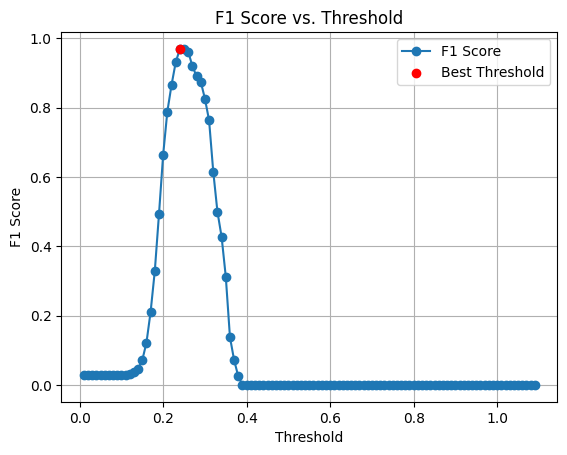

Best Threshold: 0.24000000000000002


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Change according to the class of interest
class_of_interest = 1

positive_class_probabilities = pipeline.predict_proba(X_test)[:, 1]
y_test = test_df['label'].map(label_mapping)
# Define a range of thresholds to evaluate
thresholds = np.arange(0.01, 1.1, 0.01)

# Initialize lists to store threshold and corresponding F1 score
threshold_values = []
f1_scores = []

# Iterate over the thresholds and calculate F1 score for each
for threshold in thresholds:
    predictions = positive_class_probabilities >= threshold
    f1 = f1_score(y_test == class_of_interest, predictions)
    
    # Append values to lists
    threshold_values.append(threshold)
    f1_scores.append(f1)

# Find the index of the maximum F1 score
best_threshold_index = np.argmax(f1_scores)

# Retrieve the best threshold value
best_threshold = threshold_values[best_threshold_index]

# Plot the F1 scores against the thresholds
plt.plot(threshold_values, f1_scores, marker='o', label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold')
plt.grid(True)
# Highlight the point corresponding to the best threshold
plt.scatter(best_threshold, f1_scores[best_threshold_index], color='red', label='Best Threshold', zorder=5)
plt.legend()
plt.savefig("figures/f1_score_optimum.png")
plt.show()
# Print the best threshold value
print(f"Best Threshold: {best_threshold}")

In [24]:
best_threshold

0.24000000000000002

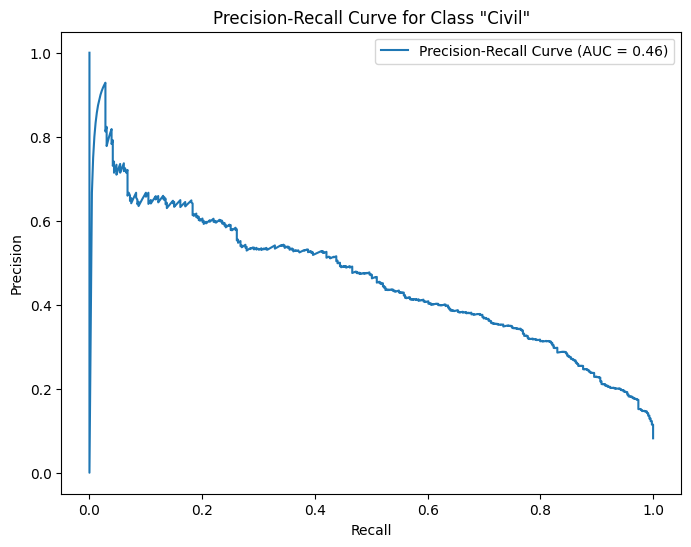

In [25]:
X_test = test_df['Cleaned_Content']
probabilities = pipeline.predict_proba(X_test)
# Change the value below accordingly
class_of_interest=2
y_test = test_df['label'].map(label_mapping)
# Get predicted probabilities on the training set using cross_val_predict
predicted_probabilities = probabilities

# Choose the class index you want to analyze (e.g., for 'civil')
class_index = pipeline.named_steps['model'].classes_.tolist().index(class_of_interest)

# Extract probabilities for the chosen class
class_probabilities = predicted_probabilities[:, class_index]

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test == class_of_interest, class_probabilities)

# Compute area under the curve (AUC) for precision-recall curve
pr_auc = auc(recall, precision)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Class "Civil"')
plt.legend()
plt.show()

## Precision-recall curve - finding optimum probability threshold

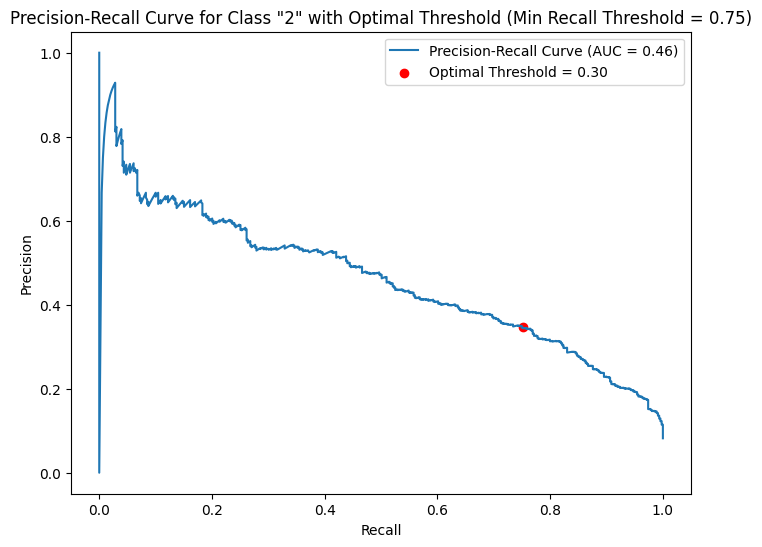

Optimal Threshold: 0.30


In [26]:
# Set a minimum recall threshold
min_recall_threshold = 0.75

# Find the index of the threshold where recall is above the minimum threshold
above_min_recall_indices = np.where(recall >= min_recall_threshold)
optimal_threshold_index = above_min_recall_indices[0][-1]  # Select the highest recall index

# Retrieve the optimal threshold
optimal_threshold = thresholds[optimal_threshold_index]

# Plot precision-recall curve with optimal threshold
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {pr_auc:.2f})')
plt.scatter(recall[optimal_threshold_index], precision[optimal_threshold_index], color='red', marker='o', label=f'Optimal Threshold = {optimal_threshold:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve for Class "{class_of_interest}" with Optimal Threshold (Min Recall Threshold = {min_recall_threshold})')
plt.legend()
plt.show()

print(f'Optimal Threshold: {optimal_threshold:.2f}')


## Definition of optimal threshold probabilities for each class 

### Without one vs all

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve, auc
import numpy as np

X_train = train_df['Cleaned_Content']

# Create an instance of OneVsRestClassifier with your model pipeline
classifier = pipeline

# Predict probabilities for each class on the test set
y_probabilities = classifier.predict_proba(X_test)

# Initialize dictionaries to store the optimal thresholds for each class
optimal_thresholds = {}

# Iterate over each class
for i in range(len(classifier.classes_)):
    class_label = classifier.classes_[i]

    # Extract probabilities and true labels for the current class
    class_probabilities = y_probabilities[:, i]
    true_labels = (y_test == class_label).astype(int)

    # Calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(true_labels, class_probabilities)

    # Find the threshold that maximizes the F1 score
    f1_scores = 2 * (precision * recall) / (precision + recall)
    optimal_threshold = thresholds[np.argmax(f1_scores)]

    # Store the optimal threshold for the current class
    optimal_thresholds[class_label] = optimal_threshold

# Use the optimal thresholds to make final predictions
final_predictions = (y_probabilities > np.array(list(optimal_thresholds.values()))).astype(int)

# Evaluate the performance of the final predictions

/tmp/ipykernel_5240/1019742136.py:30: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [28]:
# Convert the multilabel format of y_test to a multilabel-indicator format
y_test_multilabel = np.zeros_like(final_predictions)
for i in range(len(classifier.classes_)):
    y_test_multilabel[:, i] = (y_test == classifier.classes_[i]).astype(int)

# Print classification report for each class in a multilabel-indicator format
print("Classification Report:")
print(classification_report(y_test_multilabel, final_predictions, target_names=[str(label) for label in classifier.classes_]))

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      2619
           1       0.96      0.96      0.96        81
           2       0.00      0.00      0.00       459
           3       0.97      0.99      0.98      2441

   micro avg       0.89      0.88      0.88      5600
   macro avg       0.69      0.72      0.70      5600
weighted avg       0.82      0.88      0.85      5600
 samples avg       0.86      0.88      0.87      5600



/home/adelchiasta/venv/venv_doctrine/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/adelchiasta/venv/venv_doctrine/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### With one vs all

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve, auc
import numpy as np

X_train = train_df['Cleaned_Content']

# Create an instance of OneVsRestClassifier with your model pipeline
classifier = OneVsRestClassifier(pipeline)

# Fit the model
classifier.fit(X_train, y_train)

# Predict probabilities for each class on the test set
y_probabilities = classifier.predict_proba(X_test)

# Initialize dictionaries to store the optimal thresholds for each class
optimal_thresholds = {}

# Iterate over each class
for i in range(len(classifier.classes_)):
    class_label = classifier.classes_[i]

    # Extract probabilities and true labels for the current class
    class_probabilities = y_probabilities[:, i]
    true_labels = (y_test == class_label).astype(int)

    # Calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(true_labels, class_probabilities)

    # Find the threshold that maximizes the F1 score
    f1_scores = 2 * (precision * recall) / (precision + recall)
    optimal_threshold = thresholds[np.argmax(f1_scores)]

    # Store the optimal threshold for the current class
    optimal_thresholds[class_label] = optimal_threshold

# Use the optimal thresholds to make final predictions
final_predictions = (y_probabilities > np.array(list(optimal_thresholds.values()))).astype(int)

# Evaluate the performance of the final predictions

/home/adelchiasta/venv/venv_doctrine/lib64/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/adelchiasta/venv/venv_doctrine/lib64/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/adelchiasta/venv/venv_doctrine/lib64/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/adelchiasta/venv/venv_doctrine/lib64/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will 

In [31]:
# Convert the multilabel format of y_test to a multilabel-indicator format
y_test_multilabel = np.zeros_like(final_predictions)
for i in range(len(classifier.classes_)):
    y_test_multilabel[:, i] = (y_test == classifier.classes_[i]).astype(int)

# Print classification report for each class in a multilabel-indicator format
print("Classification Report:")
print(classification_report(y_test_multilabel, final_predictions, target_names=[str(label) for label in classifier.classes_]))

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      2619
           1       0.99      0.96      0.97        81
           2       0.68      0.66      0.67       459
           3       0.98      0.98      0.98      2441

   micro avg       0.93      0.93      0.93      5600
   macro avg       0.89      0.88      0.89      5600
weighted avg       0.93      0.93      0.93      5600
 samples avg       0.90      0.93      0.91      5600



/home/adelchiasta/venv/venv_doctrine/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


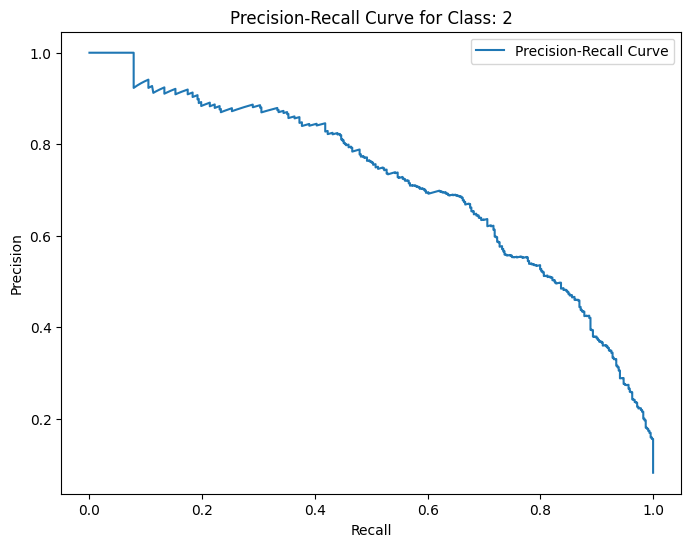

In [33]:
# Choose a specific class for which you want to plot the precision-recall curve
selected_class = 2 # Replace 'your_class_label' with the actual class label

# Find the index of the selected class in the classifier.classes_
class_index = np.where(classifier.classes_ == selected_class)[0][0]

# Extract probabilities and true labels for the selected class
class_probabilities = y_probabilities[:, class_index]
true_labels = (y_test == selected_class).astype(int)

# Calculate precision-recall curve for the selected class
precision, recall, thresholds = precision_recall_curve(true_labels, class_probabilities)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve for Class: {selected_class}')
plt.legend()
plt.show()

Confusion Matrix:
[[2541    0   58   20]
 [   4   76    0    1]
 [ 110    0  342    7]
 [  13    0    2 2426]]


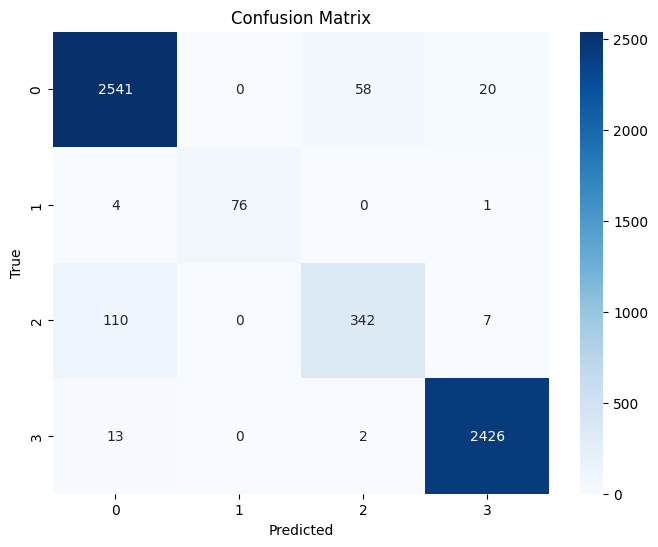

Accuracy: 0.96
Precision: 0.96
Recall: 0.96
F1 Score: 0.96


In [34]:
from sklearn import metrics
import seaborn as sns

y_true = test_df['label'].map(label_mapping)
y_pred = classifier.predict(X_test)
# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualize confusion matrix with seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Additional metrics
accuracy = metrics.accuracy_score(y_true, y_pred)
precision = metrics.precision_score(y_true, y_pred, average='weighted')
recall = metrics.recall_score(y_true, y_pred, average='weighted')
f1_score = metrics.f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")

In [39]:
import shap
from sklearn.base import is_classifier

# Assuming 'classifier' is your trained OneVsRestClassifier with an AdaBoost model inside
# 'X_test' is your test data

# Extract the inner AdaBoost model from the OneVsRestClassifier
inner_model = classifier.estimators_[0]

# Define a function that takes a single input and returns the model's predictions
def model_predict(input_data):
    # Assuming your input_data is a single sample or a batch of samples
    return inner_model.predict_proba(input_data)

# Use the SHAP explainer
explainer = shap.Explainer(model_predict)

# Calculate SHAP values for a subset of data (e.g., the first 100 samples)
shap_values = explainer.shap_values(X_test.sample(n=100))

# Summary Plot
shap.summary_plot(shap_values, X_test.sample(n=100), feature_names=feature_names)


ValueError: masker cannot be None.

In [ ]:
# Dependence Plots (for selected features, e.g., the first three features)
for feature_idx in range(3):
    shap.dependence_plot(feature_idx, shap_values[1], X_test[:100], feature_names=feature_names)

## General metrics 

In [28]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# Get predicted probabilities on the test set
probabilities = pipeline.predict_proba(X_test)

# Choose the class with the highest probability as the predicted class for each instance
predicted_classes = np.argmax(probabilities, axis=1)

# Evaluate the performance using metrics appropriate for multiclass classification
accuracy = accuracy_score(y_test, predicted_classes)
precision = precision_score(y_test, predicted_classes, average='weighted')
recall = recall_score(y_test, predicted_classes, average='weighted')
f1 = f1_score(y_test, predicted_classes, average='weighted')

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')


Accuracy: 0.90
Precision: 0.89
Recall: 0.90
F1 Score: 0.89


Confusion Matrix:
[[2489    0   97   33]
 [  12   69    0    0]
 [ 323    0  128    8]
 [ 104    0    2 2335]]


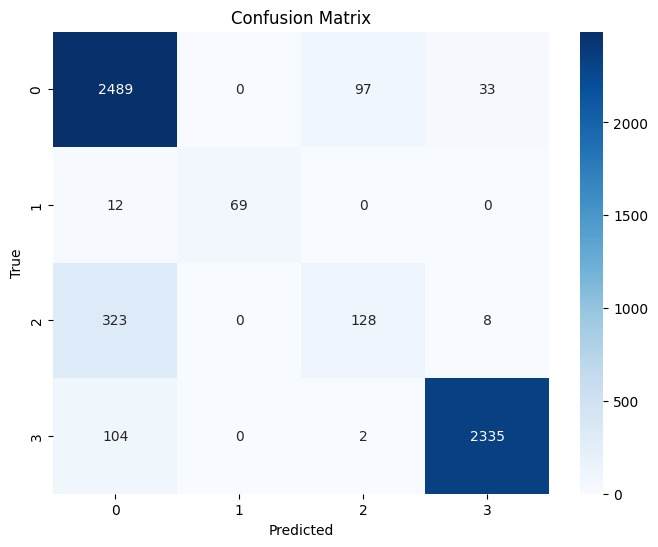

Accuracy: 0.90
Precision: 0.89
Recall: 0.90
F1 Score: 0.89


In [71]:
from sklearn import metrics
import seaborn as sns

y_true = test_df['label'].map(label_mapping)
y_pred = pipeline.predict(X_test)
# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualize confusion matrix with seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Additional metrics
accuracy = metrics.accuracy_score(y_true, y_pred)
precision = metrics.precision_score(y_true, y_pred, average='weighted')
recall = metrics.recall_score(y_true, y_pred, average='weighted')
f1_score = metrics.f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")

C:\Users\Adelchi Jacques ASTA\Documents\Dev\venv_test\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Adelchi Jacques ASTA\Documents\Dev\venv_test\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Adelchi Jacques ASTA\Documents\Dev\venv_test\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Adelchi Jacques ASTA\Documents\Dev\venv_test\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is depr

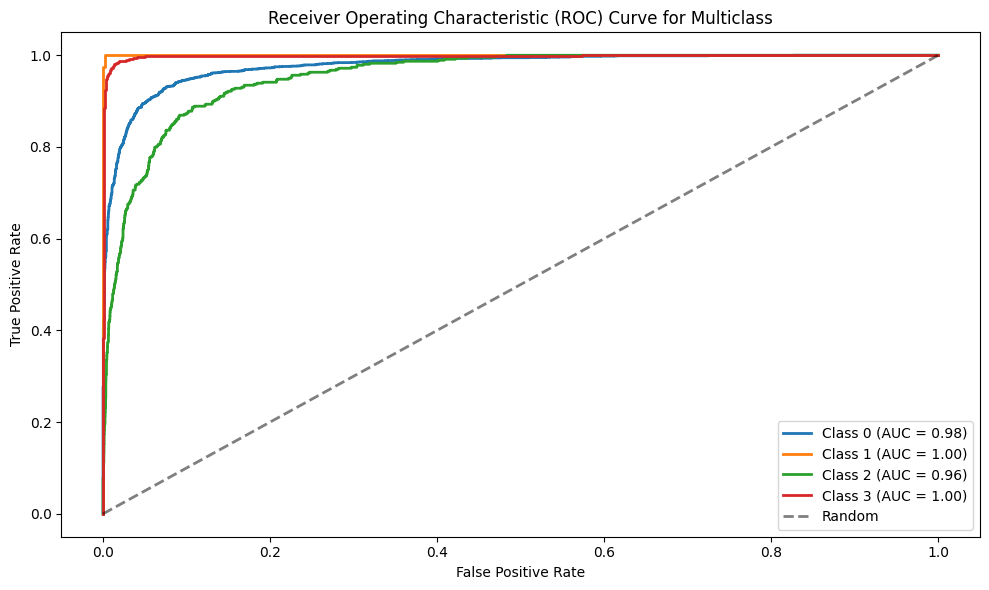

In [251]:
# Assuming adaboost_classifier is already trained
y_test = test_df['label'].map(label_mapping).copy()
y_train = train_df['label'].map(label_mapping).copy()
X_train = train_df['Cleaned_Content'].copy()
# Convert labels to binary format (one-hot encoding)
y_test_bin = label_binarize(y_test, classes=np.unique(y_train))

# Fit the classifier using OneVsRest and predict probabilities
classifier = OneVsRestClassifier(pipeline)
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(label_mapping)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 6))

for i in range(len(label_mapping)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black', label='Random', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multiclass')
plt.legend(loc='lower right')
# Apply tight layout
plt.tight_layout()

# Save the figure
plt.savefig('roc_curve.png')
plt.show()


### Checking some cases where predictions fail

In [32]:
# Predict on the training set
y_pred = pipeline.predict(X_test)
# Identify misclassified instances
misclassified_indices = np.where(y_test != y_pred)[0]

# Print a few misclassified instances and their true labels
for index in misclassified_indices[:5]:
    print(f"True Label: {y_test.iloc[index]}, Predicted Label: {y_pred[index]}")
    print(f"Text:\n{X_test.iloc[index]}\n")

True Label: 2, Predicted Label: 0
Text:
DU 20 Mars 2006 ------------------------- D.N/F.K S.A. CM CIC BAIL C/ Me Hélène X..., ès-qualités S.A. OCCITANE DE TRANSPORTS RG N : 04/01654 - A R R Ê T no 321/06 Prononcé à l'audience publique du vingt Mars deux mille six, par Jean-Louis BRIGNOL, Président de Chambre, assisté d'Isabelle LECLERCQ, Greffier LA COUR D'APPEL D'AGEN, 1ère Chambre dans l'affaire, ENTRE : S.A. CM CIC BAIL dont le siège social est 12 rue Gaillon 75002 PARIS agissant poursuites et diligences de son Président du Conseil d'Administration actuellement en fonctions domicilié en cette qualité audit siège représentée par la SCP HENRI TANDONNET, avoués assistée de la SCPA DELMOULY-GAUTHIER-THIZY, avocats APPELANTE d'une ordonnance rendue par le Juge Commissaire du Tribunal de Commerce d'AUCH en date du 1er Octobre 2004, No 2004/03797 D'une part, ET : Maître Hélène X... ès-qualités de liquidateur de la STE OCCITANE DE TRANSPORTS domiciliée ... 32000 AUCH représentée par Me Jean

### Feature importance analysis

In [33]:
pipeline.named_steps['model'].feature_importances_

array([0., 0., 0., ..., 0., 0., 0.])

In [34]:
if hasattr(pipeline.named_steps['model'], 'feature_importances_'):
    feature_importances = pipeline.named_steps['model'].feature_importances_
    feature_names = pipeline.named_steps['vectorizer'].get_feature_names_out()

    # Display the top N features
    top_features = np.argsort(feature_importances)[-10:]
    print(f"Top 10 features contributing to misclassifications:")
    for idx in top_features:
        print(f"{feature_names[idx]}: {feature_importances[idx]}")

Top 10 features contributing to misclassifications:
conformément: 0.02
exécuté: 0.02
recours: 0.02
décision: 0.02
appelée: 0.02
15: 0.02
avait: 0.02
francs: 0.04
sociale: 0.04
pénale: 0.06


In [52]:
feature_names

array(['00', '000', '01', ..., 'événement', 'êtes', 'être'], dtype=object)

## Feature analysis with table output

In [40]:
import pandas as pd

# Identify misclassified instances
misclassified_indices = np.where(y_test != y_pred)[0]

# Create a list to store data for the DataFrame
data = []

# Collect features for each misclassified instance
for index in misclassified_indices:
    true_label = y_test.iloc[index]
    predicted_label = y_pred[index]
    
    # Get the feature importances for the misclassified instance
    instance_importances = pipeline.named_steps['model'].feature_importances_
    
    # Display the top N features for the misclassified instance
    top_features = np.argsort(instance_importances)[-10:]
    
    # Create a dictionary with relevant information
    instance_data = {
        'Instance': index + 1,
        'True Label': true_label,
        'Predicted Label': predicted_label,
    }
    
    # Add top features to the dictionary
    for i, idx in enumerate(top_features, 1):
        instance_data[f'Top Feature {i}'] = feature_names[idx]
        instance_data[f'Importance {i}'] = instance_importances[idx]
    
    # Append the dictionary to the data list
    data.append(instance_data)

# Create a DataFrame from the collected data
columns = ['Instance', 'True Label', 'Predicted Label']
for i in range(1, 11):
    columns.extend([f'Top Feature {i}', f'Importance {i}'])

df_results = pd.DataFrame(data, columns=columns)

# Save the DataFrame as an Excel file
df_results.to_excel('data/misclassifications_results.xlsx', index=False)


In [51]:
for i, idx in enumerate(top_features, 1):
    print(i, feature_names[idx])

1 conformément
2 exécuté
3 recours
4 décision
5 appelée
6 15
7 avait
8 francs
9 sociale
10 pénale


In [44]:
df_results

,Instance,True Label,Predicted Label,Top Feature 1,Importance 1,Top Feature 2,Importance 2,Top Feature 3,Importance 3,Top Feature 4,...,Top Feature 6,Importance 6,Top Feature 7,Importance 7,Top Feature 8,Importance 8,Top Feature 9,Importance 9,Top Feature 10,Importance 10
0,16,2,0,conformément,0.02,exécuté,0.02,recours,0.02,décision,...,15,0.02,avait,0.02,francs,0.04,sociale,0.04,pénale,0.06
1,30,2,0,conformément,0.02,exécuté,0.02,recours,0.02,décision,...,15,0.02,avait,0.02,francs,0.04,sociale,0.04,pénale,0.06
2,46,0,2,conformément,0.02,exécuté,0.02,recours,0.02,décision,...,15,0.02,avait,0.02,francs,0.04,sociale,0.04,pénale,0.06
3,47,2,0,conformément,0.02,exécuté,0.02,recours,0.02,décision,...,15,0.02,avait,0.02,francs,0.04,sociale,0.04,pénale,0.06
4,49,2,0,conformément,0.02,exécuté,0.02,recours,0.02,décision,...,15,0.02,avait,0.02,francs,0.04,sociale,0.04,pénale,0.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574,5581,2,0,conformément,0.02,exécuté,0.02,recours,0.02,décision,...,15,0.02,avait,0.02,francs,0.04,sociale,0.04,pénale,0.06
575,5583,0,2,conformément,0.02,exécuté,0.02,recours,0.02,décision,...,15,0.02,avait,0.02,francs,0.04,sociale,0.04,pénale,0.06
576,5589,2,0,conformément,0.02,exécuté,0.02,recours,0.02,décision,...,15,0.02,avait,0.02,francs,0.04,sociale,0.04,pénale,0.06
577,5593,2,0,conformément,0.02,exécuté,0.02,recours,0.02,décision,...,15,0.02,avait,0.02,francs,0.04,sociale,0.04,pénale,0.06


In [45]:
df_results[["True Label", "Predicted Label"]].value_counts()

True Label  Predicted Label
2           0                  323
3           0                  104
0           2                   97
            3                   33
1           0                   12
2           3                    8
3           2                    2
Name: count, dtype: int64

In [46]:
df_results["Top Feature 1"].value_counts()

Top Feature 1
conformément    579
Name: count, dtype: int64

In [48]:
df["label"].value_counts(dropna=False)

label
CIV     13087
SOC     12262
COM      2265
CRIM      384
Name: count, dtype: int64